In [1]:
# Parameters
# Refer to injected parameters for any run.ipynb (similar cell below)
strain = "BY4741"
locus = "FKS1-HS2"

In [2]:
# Parameters
strain = "R1158"
locus = "FKS2-HS1"


# Notebook to plot classified variants

## Import libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["svg.fonttype"] = "none"
from upsetplot import from_indicators
from upsetplot import UpSet

## Specify paths

In [4]:
# Input
data_path = f'../classified/{"_".join([strain,locus])}/refined_classification.csv'
thresholds = f'../classified/{"_".join([strain,locus])}/thresholds.csv'

# Output
classified_outpath = f'../classified/{"_".join([strain,locus])}/'
graph_outpath = "../graphs/"

## Import data

In [5]:
df = pd.read_csv(data_path)
stddf = pd.read_csv(thresholds)

## Plot

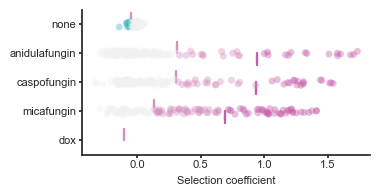

In [6]:
# Purge graph space
sns.set_theme(
    rc={
        "font.family": "Arial",
        "font.size": 8,
        "legend.title_fontsize": 8,
        "legend.fontsize": 8,
        "axes.labelsize": 8,
        "axes.titlesize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "xtick.major.pad": 2,
        "ytick.major.pad": 2,
        "xtick.bottom": True,
        "ytick.left": True,
        "xtick.major.size": 2,
        "ytick.major.size": 2,
    },
    style="ticks",
)

lclasses = [
    "resistant",
    "intermediary",
    "WT-like",
    "slightly deleterious",
    "deleterious",
]
custom_palette = ["#C75DAB", "#D691C1", "#F1F1F1", "#42B7B9", "#009B9E"]

fig = sns.catplot(
    df,
    x="s",
    y="compound",
    order=["none", "anidulafungin", "caspofungin", "micafungin"],
    hue="refined_class",
    hue_order=lclasses,
    palette=custom_palette,
    height=2,
    aspect=2,
    alpha=0.4,
    legend=False,
)

sns.boxplot(
    stddf,
    x="val",
    y="compound",
    hue="thresh",
    hue_order=["low", "up"],
    palette=["#D691C1", "#C75DAB"],
    fill=False,
    legend=False,
)

fig.set(xlabel="Selection coefficient", ylabel="")
plt.savefig(
    f'{graph_outpath}/{"_".join([strain,locus])}_classification_stripplot.svg',
    format="svg",
    dpi=300,
)

### Counts / %

In [7]:
perc = df.groupby(["compound", "sensres"])[["aa_seq"]].agg(
    nb_seq=("aa_seq", "nunique"),
)
tot = len(df.aa_seq.unique())
perc["%"] = perc.apply(lambda row: f"{row.nb_seq/tot:.1%}", axis=1)
perc

nb_seq       %
compound      sensres                    
anidulafungin resistant        28   21.2%
              sensitive       104   78.8%
caspofungin   resistant        36   27.3%
              sensitive        96   72.7%
dox           deleterious       5    3.8%
              sensitive       127   96.2%
micafungin    resistant        82   62.1%
              sensitive        50   37.9%
none          sensitive       132  100.0%

### Show distributions

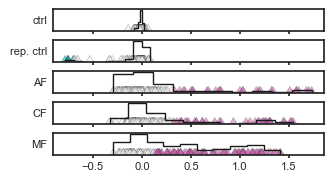

In [8]:
graphdf = df

abrev_drugs = {
    "none": "ctrl",
    "dox": "rep. ctrl",
    "anidulafungin": "AF",
    "caspofungin": "CF",
    "micafungin": "MF",
}
lclasses = ["resistant", "sensitive", "deleterious"]
custom_palette = ["#C75DAB", "#F1F1F1", "#009B9E"]

rc_dict = {
    "figure.figsize": (3.5, 1.9),
    "font.family": "Arial",
    "font.size": 8,
    "legend.title_fontsize": 8,
    "legend.fontsize": 8,
    "axes.labelsize": 8,
    "axes.titlesize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "xtick.major.pad": 2,
    "ytick.major.pad": 2,
    "xtick.bottom": True,
    "ytick.left": False,
    "xtick.major.size": 2,
    "ytick.major.size": 2,
}
plt.rcParams.update(rc_dict)
fig, ax = plt.subplots(
    len(graphdf.compound.unique()), 1, sharex=True, gridspec_kw={"hspace": 0.4}
)

for i, c in enumerate(
    [x for x in abrev_drugs.keys() if x in graphdf.compound.unique()]
):
    axdf = graphdf[graphdf.compound == c]
    ax[i].hist(axdf.s, histtype="step", color="k")
    ax[i].scatter(
        axdf.s,
        np.zeros(axdf.s.shape),
        marker="d",
        s=50,
        c=axdf.sensres.map(dict(zip(lclasses, custom_palette))),
        edgecolors="k",
        linewidths=0.25,
        alpha=0.5,
    )
    ax[i].set_yticks([])
    ax[i].set_ylabel(abrev_drugs[c], rotation=0, ha="right", va="center")

plt.savefig(
    f'{graph_outpath}/{"_".join([strain,locus])}_distribution_effects_rug.svg',
    format="svg",
    dpi=300,
)

## UpSet plot on classified variants

In [9]:
parse_dict = {"resistant": True, "sensitive": False, "deleterious": False}

In [10]:
BYnnkCompWide = df.pivot_table(
    index="aa_seq", columns="compound", values=["s", "sensres"], aggfunc="first"
).reset_index()
BYnnkCompWide["max_s"] = BYnnkCompWide["s"].max(axis=1)
bincat = BYnnkCompWide["sensres"].replace(parse_dict)
bincat.rename(
    columns={
        "anidulafungin": "AF",
        "caspofungin": "CF",
        "micafungin": "MF",
        "none": "ctrl",
    },
    inplace=True,
)
compounds = ["AF", "CF", "MF"]
bincat = pd.concat([bincat, BYnnkCompWide[["max_s"]].droplevel(1, axis=1)], axis=1)
bincat

/tmp/ipykernel_37456/1649639105.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bincat = BYnnkCompWide["sensres"].replace(parse_dict)


,AF,CF,dox,MF,ctrl,max_s
0,False,False,False,False,False,0.168717
1,True,True,False,True,False,0.731288
2,False,False,False,True,False,0.289395
3,False,False,False,True,False,0.326257
4,False,False,False,False,False,-0.019270
...,...,...,...,...,...,...
127,False,False,False,True,False,0.157443
128,True,False,False,True,False,0.842732
129,False,False,False,True,False,0.334010
130,False,False,False,True,False,0.156567


In [11]:
bincat.ctrl.unique()

array([False])

In [12]:
bincat.to_csv(f"{classified_outpath}/upsetplot.csv")

In [13]:
bincat = pd.read_csv(f"{classified_outpath}/upsetplot.csv", index_col=0)

No support for this hotspot


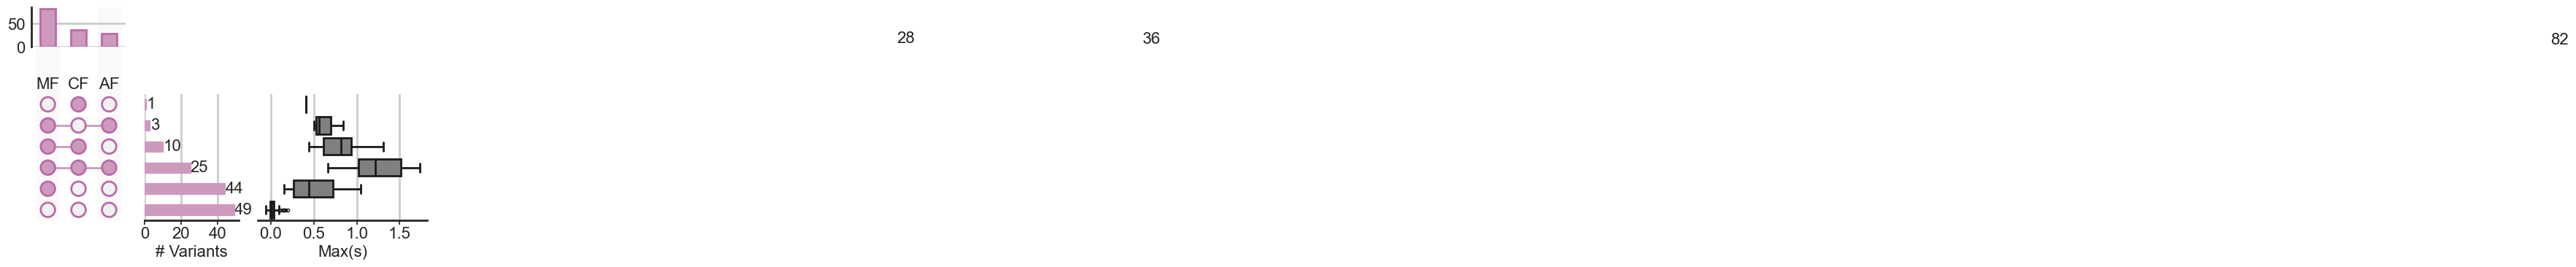

In [14]:
# Manuscript version
# For this plot, all sizes are doubled and the graph is ultimately reduced by 50% for the final panel

rc_dict = {
    "font.family": "Arial",
    "font.size": 16,
    "axes.linewidth": 2,
    "grid.linewidth": 2,
    "axes.labelsize": 16,
    "axes.titlesize": 16,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "xtick.major.pad": 2,
    "ytick.major.pad": 2,
    "xtick.major.size": 4,
    "ytick.major.size": 4,
}

upset_obj = UpSet(
    from_indicators(compounds, data=bincat),
    orientation="vertical",
    facecolor="#cd9abe",
    other_dots_color="#F1F1F1",
    # show_percentages=True,
    show_counts=True,
    # min_subset_size=10,
    sort_by="cardinality",
    element_size=None,
    intersection_plot_elements=3,  # height/width of intersection barplot in matrix elements # needs to be 0 to be able to draw stacked_barplot
    totals_plot_elements=2,  # width/height of totals barplot in matrix elements
)

upset_obj.add_catplot(
    value="max_s",
    kind="box",
    color="grey",
    fliersize=3,
    linewidth=2,
    linecolor="k",
    elements=5,  # height in number of matrix elements
)

fig = plt.figure(figsize=(7, 3.8))

with plt.rc_context(rc_dict):
    d = upset_obj.plot(
        fig=fig
    )  # Assigns all plots to a dictionary containing axes subplots - same keys as gridspec returned by upset_obj.make_grid()

axt = d["totals"]
axm = d["matrix"]
ax0 = d[
    "intersections"
]  # Key corresponding to stacked barplot ('intersections' = intersection barplot)
ax1 = d["extra1"]  # Key corresponding to additional plot, in this case catplot

for i in [0, 1, 2]:
    axt.get_children()[i].set_color("#cd9abe")
    axt.get_children()[i].set_edgecolor("#ba6aa5")
    axt.get_children()[i].set_linewidth(2)

axm.set_xticklabels(axm.get_xticklabels(), rotation=0, ha="center")
axm.get_children()[0].set_edgecolor("#ba6aa5")
axm.get_children()[0].set_linewidth(2)

ax0.set_xlabel("# Variants")  # (unique aminoacid sequences)
ax1.set_xlabel("Max(s)")

if locus == "FKS1-HS1":
    for i in [0, 1, 2, 3, 4, 5, 6, 7]:
        ax0.get_children()[i].set_linewidth(2)
        if i <= 5:
            ax0.get_children()[i].set_color("grey")
            ax0.get_children()[i].set_edgecolor("k")
        elif i == 6:
            ax0.get_children()[i].set_color("#F1F1F1")
            ax0.get_children()[i].set_edgecolor("#b0b0b0")
        else:
            ax0.get_children()[i].set_edgecolor("#ba6aa5")

    ax1.get_children()[42].set_facecolor("#F1F1F1")
    ax1.get_children()[49].set_facecolor("#cd9abe")

elif locus == "FKS1-HS2":
    for i in [0, 1, 2, 3, 4, 5]:
        ax0.get_children()[i].set_linewidth(2)
        if i < 4:
            ax0.get_children()[i].set_color("grey")
            ax0.get_children()[i].set_edgecolor("k")
        elif i == 4:
            ax0.get_children()[i].set_edgecolor("#ba6aa5")
        else:
            ax0.get_children()[i].set_color("#F1F1F1")
            ax0.get_children()[i].set_edgecolor("#b0b0b0")
    ax1.get_children()[28].set_facecolor("#cd9abe")
    ax1.get_children()[35].set_facecolor("#F1F1F1")

elif locus == "FKS1-HS3":
    for i in [0, 1, 2, 3, 4, 5, 6]:
        ax0.get_children()[i].set_linewidth(2)
        if i <= 4:
            ax0.get_children()[i].set_color("grey")
            ax0.get_children()[i].set_edgecolor("k")
        elif i == 5:
            ax0.get_children()[i].set_edgecolor("#ba6aa5")
        else:
            ax0.get_children()[i].set_color("#F1F1F1")
            ax0.get_children()[i].set_edgecolor("#b0b0b0")

    ax1.get_children()[42].set_facecolor("#F1F1F1")
    ax1.get_children()[35].set_facecolor("#cd9abe")

else:
    print("No support for this hotspot")

plt.savefig(
    f"{graph_outpath}/upsetplot_resistance_overlap_{strain}_{locus}.svg",
    format="svg",
    dpi=300,
)